### HOG : Histogram of Oriented Gradients

![](img\hog1a.png)
![](img\hog2.png)

### Let's build it by Hand ...
There is built-in code in skimage and cv2. But let's build it up from scratch!! It won't be as good as the code from the library but at least you get to see the implementation in detail.

In [2]:
def myhog(img):
    '''
    Basic implementation of Histogram of Oriented Gradients
    '''
    print(img.shape)
    
    #gets the edges for the entire image
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    
    #direction and magnitude of the edges
    mag, ang = cv2.cartToPolar(gx, gy) 
    
    bin_n = 16 # Number of bins in histogram
    bin = np.int32(bin_n*ang/(2*np.pi)) #scale it to bin_n
    
    bin_cells = []
    mag_cells = []

    #HoG window size
    cellx = celly = 8

    #scan through entire image
    for j in range(0,int(img.shape[0]/celly)):
        for i in range(0,int(img.shape[1]/cellx)):
            # collect the rotation (bin number) and magnitude from 8 by 8 cells
            bin_cells.append(bin[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            mag_cells.append(mag[i*celly : i*celly+celly, j*cellx : j*cellx+cellx])
            
    
    #total cells= height/8 x width/8
    #each cell has 16 numbers in each bin: each bin is direction, value in bin is magnitude
    #therefore hist has 16 x total cells
    #note: ravel is to flatten the list
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
        
    #Convert to Hellinger kernel so that histogram can be 
    #compared using Euclidean distance for better histogram comparison results
    #see: [Arandjelovic et al. 2012].
    # Euclidean  distance  can  be dominated by  large  bin values
    # Hellinger distance  makes it more  sensitive  to  smaller bin  values
    
    nearzero = 1e-7  #this is supplied to prevent any divide-by-zero errors
    hist /= hist.sum() + nearzero #L1-normalize. 
    hist = np.sqrt(hist)
    return hist

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, io, filters


def getHoG(img):

    r,c=img.shape #grayscale 1 channel only
    box=int(r/8) #8 is the size of the hog window

    hist=myhog(img) #histogram returned is a list for easy comparison

    #reshape into 2D
    hista=np.array(hist)
    hista=np.reshape(hist,(box,box,16))
    print(hista.shape)

    return hista


In [4]:
import math

def mag_ang(x1,y1,length, theta):
    x2 =x1+ length * math.cos(theta)
    y2 =y1+ length * math.sin(theta) 
    return x2,y2


In [5]:
def displayHoG(hista,size):
    '''
    Displays only the largest gradient component (as a normal vector).
    '''
    plt.figure(figsize=(8,8))
    plt.axis('off')
    for y in range(int(size/8)):
        for x in range(int(size/8)):
            #retrieve line
            ang=np.argmax(hista[x,y]) #bin number
            mag=np.max(hista[x,y,ang])
            x1=x+8
            y1=y-8
            x2,y2=mag_ang(x1,y1,20*mag,ang)
            #print(x1,y1,'-',x2,y2)
            plt.plot([x1, x2], [size-y1, size-y2])

    plt.show()        

(512, 512)
(64, 64, 16)


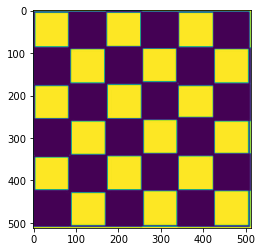

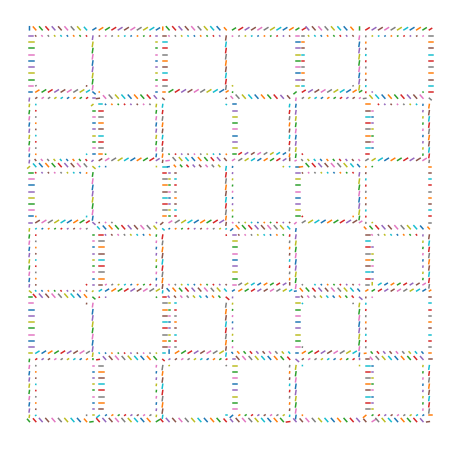

In [6]:
#img = data.camera()
#only square images please
img=cv2.imread("img/chessboard.png", cv2.COLOR_BGR2GRAY)

(img, G, R) = cv2.split(img) #use only 1 channel
plt.imshow(img)
size,_=img.shape #assume is square
Hog=getHoG(img)
displayHoG(Hog, size)

### HoG Using Sci-kit Image

Try changing pixels_per_cell values

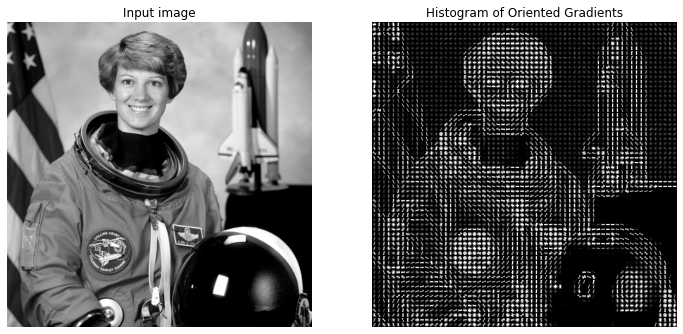

In [16]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, color, exposure


image = color.rgb2gray(data.astronaut())

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
#ax1.set_adjustable('box')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
#ax1.set_adjustable('box')
plt.show()

### Question

1. How would you detect an object in an image using HoG? Explain.

        Answer.
        
 - HoG detects edges and direction of an image by extracting the gradient and orientation ( magnitude and direction) of the edges.
- The complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated.
- Finally the HOG would generate a Histogram for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values.

### Object Detection

Can HoG find this car?
![](img\car.png)

In this image ![](img\car-on-road.png)

(128, 128, 3)
Top Match = 11.560390659534425


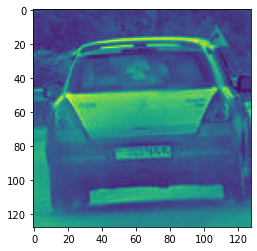

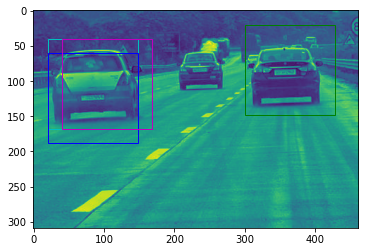

In [17]:
#Try detecting a car on the road ...
from skimage import io
import matplotlib.patches as patches

def HoGDistance(h1,h2):
    diff=[math.sqrt(abs(i-j)) for i,j in zip(h1,h2)]
    sum=np.array(diff).sum()
    return sum

#This is the object we want to detect, so we get its HoG first
image=io.imread('img\car.png') 
object = color.rgb2gray(image)
print(image.shape)
h1 = hog(object, orientations=8, pixels_per_cell=(32, 32),cells_per_block=(4, 4), visualize=False)
#print(len(fd))

image=io.imread('img\car-on-road.png')
(image, G, R) = cv2.split(image) #use only 1 channel
r,c=image.shape

window=128
skip=20
data=[]
win=[]
for i in range(0,r-window,skip):
    for j in range(0,c-window,skip):
        subimg=image[i:i+window,j:j+window]
        #print(i,i+window,j,j+window)
        h2, img = hog(subimg, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(4, 4), visualize=True)
        #plt.imshow(subimg)
        #plt.show()
        data.append(HoGDistance(h1,h2))
        win.append((i,j))

#get the smallest distance
data=np.array(data)
i=np.argmin(data)
#retrieve the window coordinates of the smallest distance value
x,y=win[i]

#extract the subimage
match=image[x:x+window,y:y+window]
print('Top Match =',data[i])
plt.imshow(match)
plt.show()

#display the rest of matches, sort the data in ascending order by its index
indices=np.argsort(data)

fig, ax = plt.subplots()
plt.imshow(image)    
c=['c','b','m','g']
for i in range(0,4):
    x,y=win[indices[i]]
    
    rect = patches.Rectangle((y, x), window, window, linewidth=1, edgecolor=c[i], facecolor='none')
    ax.add_patch(rect)

plt.show()


### Question


1. Create your own object and test image, test with the above code.
1. Can the above code detect objects well? What are the weaknessess of this method of object detection?

<ipython-input-18-a59cf0fb585f>:12: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  object = color.rgb2gray(image)


(369, 277, 4)
Top Match = 1012.6845217631069


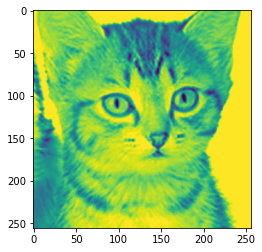

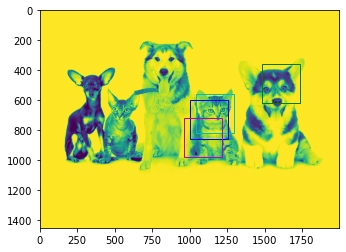

In [18]:
#Try detecting a car on the road ...
from skimage import io
import matplotlib.patches as patches

def HoGDistance(h1,h2):
    diff=[math.sqrt(abs(i-j)) for i,j in zip(h1,h2)]
    sum=np.array(diff).sum()
    return sum

#This is the object we want to detect, so we get its HoG first
image=io.imread('myImg\smallDog.png') 
object = color.rgb2gray(image)
print(image.shape)
h1 = hog(object, orientations=8, pixels_per_cell=(32, 32),cells_per_block=(4, 4), visualize=False)
#print(len(fd))

image=io.imread('myImg\dog-and-cats-3.jpg')
(image, G, R) = cv2.split(image) #use only 1 channel
r,c=image.shape

window=256
skip=40
data=[]
win=[]
for i in range(0,r-window,skip):
    for j in range(0,c-window,skip):
        subimg=image[i:i+window,j:j+window]
        #print(i,i+window,j,j+window)
        h2, img = hog(subimg, orientations=16, pixels_per_cell=(32, 32), cells_per_block=(4, 4), visualize=True)
        #plt.imshow(subimg)
        #plt.show()
        data.append(HoGDistance(h1,h2))
        win.append((i,j))

#get the smallest distance
data=np.array(data)
i=np.argmin(data)
#retrieve the window coordinates of the smallest distance value
x,y=win[i]

#extract the subimage
match=image[x:x+window,y:y+window]
print('Top Match =',data[i])
plt.imshow(match)
plt.show()

#display the rest of matches, sort the data in ascending order by its index
indices=np.argsort(data)

fig, ax = plt.subplots()
plt.imshow(image)    
c=['c','b','m','g']
for i in range(0,4):
    x,y=win[indices[i]]
    
    rect = patches.Rectangle((y, x), window, window, linewidth=1, edgecolor=c[i], facecolor='none')
    ax.add_patch(rect)

plt.show()

### Answer
         
         
        This method is not efficient in detecting the object. It is has a high error rate and it amplifies the noise in the image as shown in the image that I have tried to detect above. However, it has some success rate though not accurate.